### Trabalho II - Introdução à Teoria da Informação

*Alunos*:  Itamar Filho - 20180026510, João Pedro Teixeira - 20180028453, Igor Simões - 20220024150

### Reconhecimento de Padrões baseado em LZW

O algoritmo LZW, implementação na primeira parte do projeto, foi usado para a 

### Leitura do banco de imagens

Foi feita a leitura de cada imagem presente no banco extraidos os valores dos seus pixels.

In [3]:
from compression.helpers import read_data
import numpy as np
import time
import copy

A função abaixo é responsável por remover os cabeçalhos de todos os arquivos

In [4]:
def remove_headers():
    for i in range(1,41):
        for j in range(1,11):
            with open(f"test/data/orl_faces/s{i}/{j}.pgm", "rb") as f:
                lines = f.readlines()
            
            with open(f"test/data/processed_orl_faces/s{i}/{j}.pgm", "wb") as processed_f:
                processed_f.writelines(lines[3:])


In [6]:
remove_headers()

In [7]:
def get_images():
    images = []
    for i in range(1,41):
        person_images = []
        for j in range(1,11):
            person_images.append(read_data(f"test/data/processed_orl_faces/s{i}/{j}.pgm")[0])
        images.append(person_images)
    return images

## Cross Validation

Neste passo, para criar o banco de dados de treino e teste, foi definida para cada pessoa, de forma aleatória, uma imagem. As 9 imagens das faces restantes foram usadas para popular os dados de treinamento

In [9]:
def cross_validation(images):
    training_images = []
    testing_images = []

    images_copy = copy.deepcopy(images)   
    for i in range(0,len(images_copy)):
        test_index = np.random.choice(10)
        testing_images.append(images_copy[i].pop(test_index))
        training_images.append(images_copy[i])
    return training_images, testing_images

## Training

Para a etapa de treinamento, foi gerado um dicionário para cada pessoa baseado na partição de treino dos dados.

O dicionário é preenchido com os dados de cada imagem.

In [10]:
from compression.lzw import LZW


def train(images, dicts, k):
    lzw = LZW(dictionary_k=k)
    data_set = {i for i in range(2**8)}
    for i, person_images in enumerate(images):
        for image in person_images:
                _, dicts[i], _ = lzw.encode(image, data_set.copy(), existing_dict=dicts[i], verbose=False, incremental=True)

    return dicts

## Testing

Usando o algoritmo de compressão do LZW, o modelo foi testado com base nos 40 dicionários gerados.
A imagem também foi identificada de acordo com a classe com melhor taxa de compressão.
No final, é retornada a acurácia da classificação bseada na contagem de imagens classificadas de forma correta

In [11]:
def test(test_images, dicts, k, verbose: bool) -> float:
    lzw = LZW(dictionary_k=k)
    data_set = {i for i in range(2**8)}
    accuracy_result = []
    
    for i, image in enumerate(test_images):
        compression_size = []

        for j in range(40):
            output, _, _ = lzw.encode(image, data_set, existing_dict=dicts[j], verbose=False, incremental=False) # needs required arguments
            compression_size.append(len(output))

        accuracy_result.append(i  == compression_size.index(min(compression_size)))
    
    accuracy = 100 * accuracy_result.count(True) / len(accuracy_result)
    if verbose:
        print(f"Modelo com acurácia para k = {k}: {accuracy}%")
    return accuracy 

## Main function

A função principal é responsável por invocar as funções e realizar o preenchimento dos 40 dicionários particionando os dados entre treino e teste e, de fato, retornar o resultado do teste com base no treinamento realizado. 

In [12]:
def train_test(images, k):
    train_start = time.time()
    dicts = []
    data_set = {i for i in range(2**8)}
    dictionary = {(value,): i for i, value in enumerate(data_set)}

    for i in range(40):
        dicts.append(dictionary.copy())

    training_images, testing_images = cross_validation(images)

    dicts = train(training_images, dicts, k)

    return test(testing_images, dicts, k, verbose=True), time.time() - train_start

## Running

Nesta etapa, é realizado o objetivo final: treinamento e teste para valores de K no intervalo de 9 a 16.

In [13]:
images = get_images()
accs = []
times = []

for k in range(9,17):
    accuracy, training_time = train_test(images, k)
    accs.append(accuracy)
    times.append(training_time)

Modelo com acurácia para k = 9: 22.5%
Modelo com acurácia para k = 10: 10.0%
Modelo com acurácia para k = 11: 15.0%
Modelo com acurácia para k = 12: 27.5%
Modelo com acurácia para k = 13: 70.0%
Modelo com acurácia para k = 14: 67.5%
Modelo com acurácia para k = 15: 85.0%
Modelo com acurácia para k = 16: 97.5%


## Plots

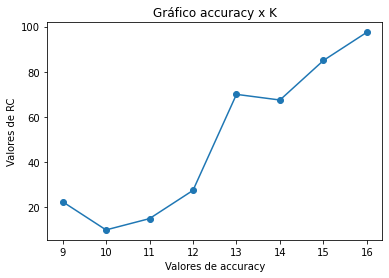

In [14]:
from matplotlib import pyplot as plt

plt.plot(range(9,17), accs)
plt.scatter(range(9,17), accs)
plt.title('Gráfico accuracy x K')
plt.xlabel('Valores de accuracy')
plt.ylabel('Valores de RC')
plt.show()

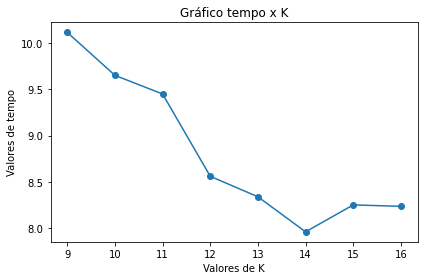

In [15]:
plt.plot(range(9,17), times)
plt.scatter(range(9,17), times)
plt.title('Gráfico tempo x K')
plt.xlabel('Valores de K')
plt.ylabel('Valores de tempo')
plt.tight_layout()
plt.show()

### Conclusão

O parâmetro K mostra-se determinante na acurácia do modelo, tendo relação proporcional. O valor de acurácia máximo obtido foi de 90% para K=15.
O motivo dessa relação esta baseado no fato de que a codificação depende da magnitude do dicionário gerado, o que gera a possibilidade de uma quantidade maior de bytes ser traduzido em um único índice.

Ainda é importante ressaltar o fator de semelhança esperada e natural entre os dados dos píxeis de uma foto da mesma pessoa e que, ao usar um dicionário da classe correspondente, o padrão será codificado na imagem de teste com menor necessidade de índices.
Portanto, fica evidente que quanto maior o dicionário melhor a capacidade de classificação

Vale ressaltar o fator tempo em função do aumento do parâmetro K, que aumenta de forma exponencial como observado no gráfico. Essa métrica não inviabiliza o uso de K maiores dado o potencial de acurácia elevada para este último caso. 

#### Respostas das diretrizes do projeto:

**1. Utilizou qual banco de dados?**
- Foi utilizado o ORL Database of Faces

**2.Se foi um banco de dados de imagem, descartou o cabeçalho do arquivo e usou apenas a sequência de pixels?**

- Sim

**3. Utilizou qual linguagem de programação?**

- Python

**4. Gerou o banco de treinamento e o arquivo de teste de forma aleatória? Ficaram quantos arquivos para treino e quantos para classificação?**

- Os dados de treinamento e teste foram gerados de forma aleatória. Para cada pessoa, 1 imagem para teste e 9 para treino

**5. Testou com todos os K (9 a 16 no LZW ou 0 a 8 no PPM)?**

- Sim. o K variou entre 9 e 16 para o LZW.

**6. O dicionário ficou estático durante a classificação?**

- Sim.

**7. Apresentou as curvas de Taxa de Acerto x K e de Tempo de Processamento x K? Lembrando que K deve estar no eixo X.**

- Sim. Foram apresentados os gráficos.

**8. Usou qual métrica de distância? Tamanho do arquivo ou quantidade de índices?** 

- Quantidade de índices.
